# CS217 : Assignment 3  :  Reflectance and Photometric Stereo

---
Please edit the cell below to include your name and student ID #

**name:** Shi Zeng

**SID:** 45167563

# 1. Reflectance and Lighting Direction

You take an image of a sphere of radius $r$ whose center projects to image position (0, 0). To simplify things, we will assume that the sphere is far from the camera relative to the radius of the sphere and use an orthographic projection model $(x,y,z) \rightarrow (x,y)$ rather than our usual perspective model $(x,y,z) \rightarrow (x/z,y/z)$. The sphere is illuminated from above by a distant point light source. Let $(a,b)$ be the location of the brightest point on the sphere as seen by the camera where $a^2 + b^2 \leq r^2$ 

## 1.1  Lambertion Reflectance

Assume the sphere is a diffuse material and behaves as an ideal lambertian object. Find the direction of the point light source as a function of $(a,b)$. The direction is given by a unit length vector pointing from the center of the sphere toward the point light source. Hint: Express the equation for a sphere in terms of z to get a height field.


<img src="1.png">

Assume the 3D coordinate system is $XYZ$, with the original point $(0, 0, 0)$ being the center of the sphere. Assume the distance between the sphere and the image plane is $h$.

The brightest point $P$ on surface circle is projected to point $P^{'} = (a, b)$ in the image coordinate system. As the orthographic model is $(x, y, z) \to (x, y)$, thus, the coordinate of $P^{'}$ in 3D system is $(a, b, -h)$. The coordinate of $P$ is $(a, b, 0)$ in the 3D coordinate system.

Because the image irradiance of lambertian object is $$I = \frac{\rho_d}{\pi} kc \cos{\theta}$$

with $\rho_d$ being the surface albedo, $k$ being the source brightness, $c$ being optical system scalar. Therefore, the brightest point is where the angle between reflected outgoing light and normal vector of surface being $0$. Therefore, the direction of the light source is the direction the point where the incoming light and the sphere intersects. The direction is $(a, b, z)$ where $z$ is $$z = \sqrt{r^2 - a^2 - b^2}$$

Thus, the normalized source light direction is $$v = N = (\frac{a}{r}, \frac{b}{r}, \frac{\sqrt{r^2 - a^2 - b^2}}{r})$$

## 1.2  Specular Reflectance

Assume the sphere is chrome and behaves as a ideal reflector. Find the direction of the point light source as a
function of $(a,b)$

For a perfect specular reflection, the angle between surface normal and the incoming source light is the same as the angle between surface normal and the outgoing light. Since the sphere is far away from the camera, the outgoing light of $v$ can be considered as parallel to $Z$ axis.

Therefore, the angle between outgoing light $v$ and normal vector is $$\cos{\theta} = \frac{z}{r} = \frac{\sqrt{r^2 - a^2 - b^2}}{r}$$

The incoming light direction is the symmetric light of $L^{'}$ by the surface normal vector $N$. Let $v = (0, 0, 1)$, in the parallelogram of $L^{'}$, $N_s$ and $L$, $$|N_s| = 2|v| \cos{\theta} = \frac{2\sqrt{r^2 - a^2 - b^2}}{r}$$
$$N_s = N \cdot |N_s|$$
$$L = N_s - L^{'} = (\frac{2a\sqrt{r^2 - a^2 - b^2}}{r^2}, \frac{2b\sqrt{r^2 - a^2 - b^2}}{r^2}, \frac{r^2 - 2a^2 - 2b^2}{r^2})$$


# 2. Lighting Recovery

Download the set of images provided on Canvas.  Write code that loads in each of the 11 chrome-ball images and determines the light source direction by finding the brightest point on the image and utilizing your derivation above. Represent the lighting direction by a unit vector pointing in the direction of the light source. Print out and visualize the resulting vectors in a plot and verify that they match your intuition from looking at the images.

In [1]:
%matplotlib notebook
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
chrome_dir = 'data/chrome'
owl_dir = 'data/owl'

N = 13
W = 512
H = 340
thres = 255

imgs = np.zeros((N - 1, H, W))
mask = np.zeros((H, W))
for i in range(N):
    if i != N - 1:
        img = Image.open(os.path.join(chrome_dir, 'chrome.' + str(i) + '.png'))
        img = np.array(img.convert('L'))
        imgs[i, :, :] = img
    else:
        img = Image.open(os.path.join(chrome_dir, 'chrome.mask.png'))
        img = np.array(img.convert('L'))
        mask = img
        mask[mask < thres] = 0
        mask[mask >= thres] = 1

<IPython.core.display.Javascript object>


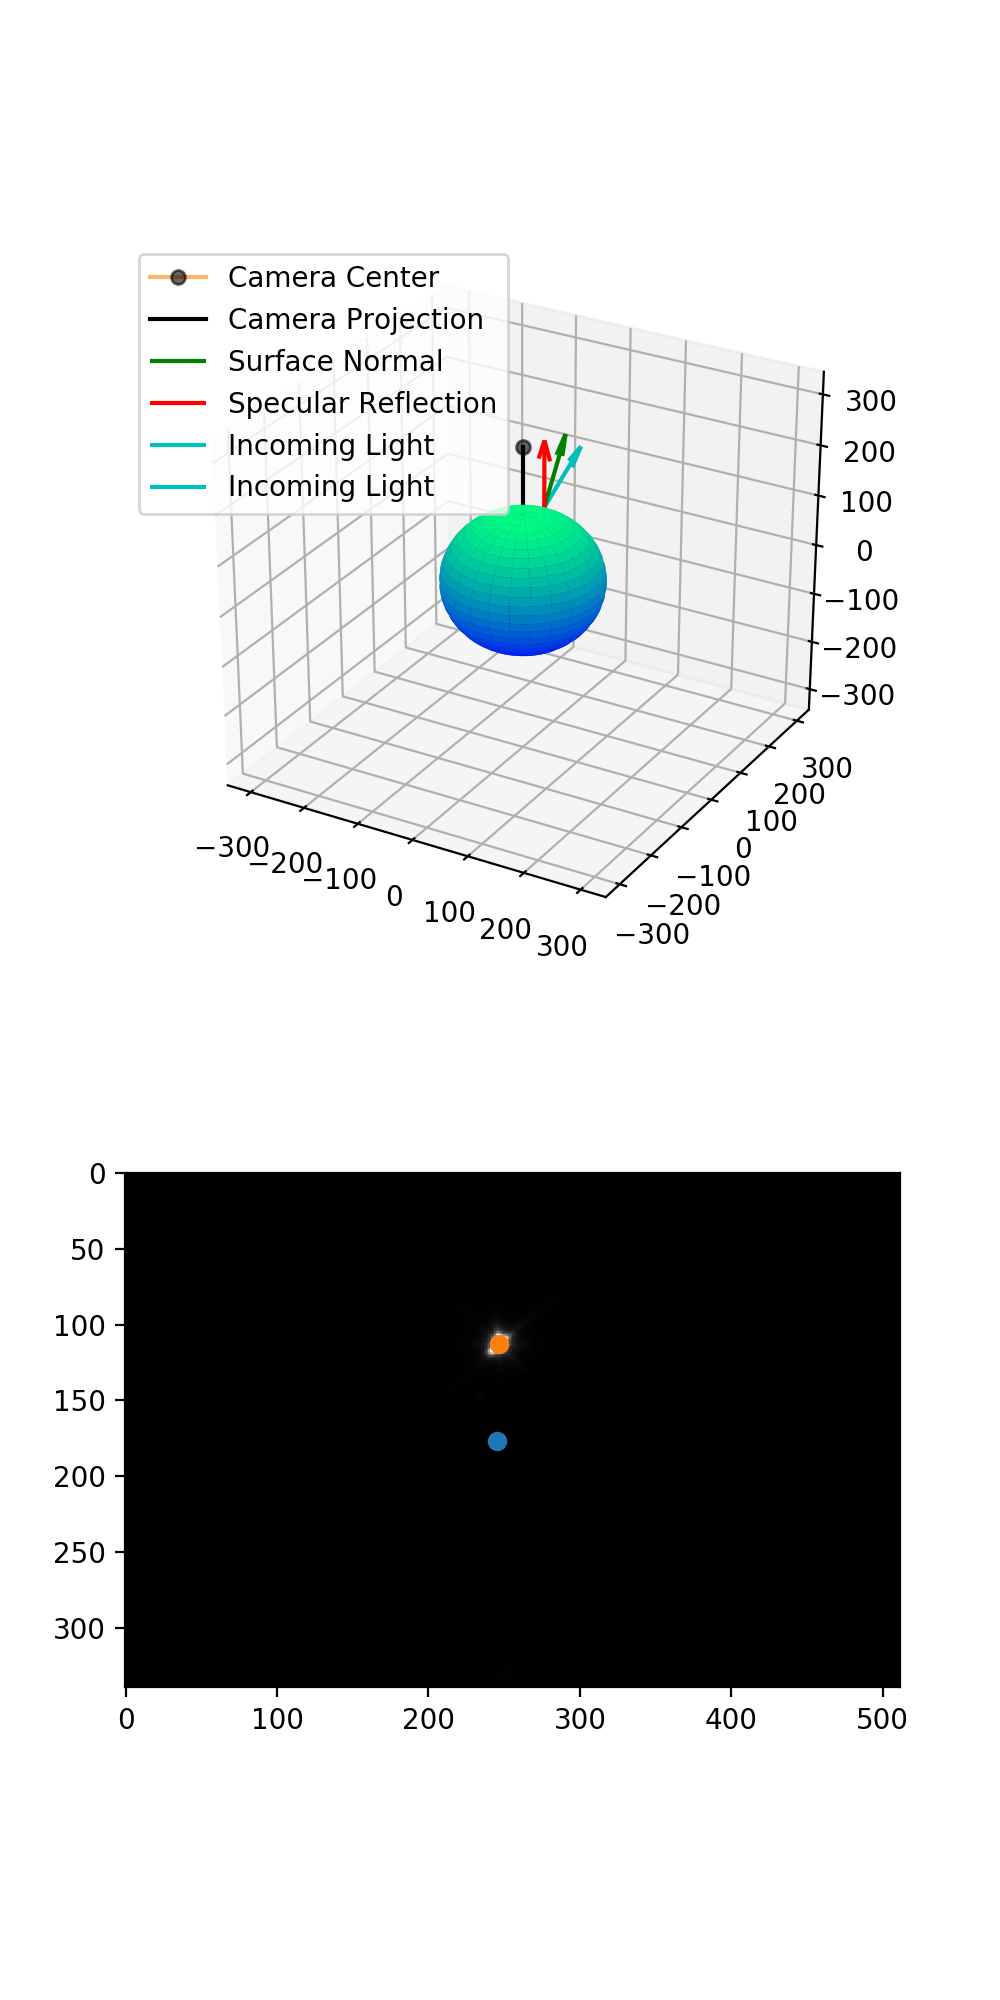

In [23]:
def decode_mask(img):
    peak = np.max(img)
    coords = np.argwhere(img == peak)
    y_min = np.min(coords[:, 0])
    y_max = np.max(coords[:, 0])
    x_min = np.min(coords[:, 1])
    x_max = np.max(coords[:, 1])
    py = (y_max + y_min) / 2.0
    px = (x_max + x_min) / 2.0
    radius = (x_max - x_min) / 2.0
    return px, py, radius

def bright_point(img):
    peak = np.max(img)
    coords = np.argwhere(img == peak)
    size = coords.shape[0]
    py = np.sum(coords[:, 0]) / size
    px = np.sum(coords[:, 1]) / size
    return px, py

def light_calib(imgs, cx, cy, r):
    R = np.array([0, 0, 1.])
    N = imgs.shape[0]
    L = np.zeros((N, 3))
    for i in range(N):
        px, py = bright_point(imgs[i, :, :])
        a = px - cx
        b = -(py - cy)
        z = np.sqrt(r**2 - a**2 - b**2)
        normal = np.array([a, b, z])
        normal /= r
        L[i, :] = 2 * np.dot(normal, R) * normal - R
    return L

def vis_light(imgs, L, cx, cy, r, i):
    fig = plt.figure(figsize=(5, 10))
    px, py = bright_point(imgs[i, :, :])
    a = px - cx
    b = -(py - cy)
    ax = fig.add_subplot(2, 1, 1, projection='3d')

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, rstride=4, cstride=4, cmap=cm.winter)
    camera = ax.plot([0], [0], [2 * r], markerfacecolor='k', markeredgecolor='k', marker='o', 
                     markersize=5, alpha=0.6, label='Camera Center')
    center = ax.plot([0, 0],[0, 0],[r, 2 * r], color='k', label='Camera Projection')
    root = np.sqrt(r**2 - a**2 - b**2)
    normal = ax.quiver(a, b, root, a, b, root, color='g', label='Surface Normal')
    ax.quiver(a, b, root, 0, 0, r, color='r', label='Specular Reflection')
    ax.quiver(a, b, root, 
              (2 * a * root) / r**2, (2 * b * root) / r**2, (r**2 - 2 * a**2 - 2 * b**2) / r**2, 
              color = 'c', label='Incoming Light')
    light = L[i, :] * r
    ax.quiver(a, b, root, 
              light[0], light[1], light[2], 
              color = 'c', label='Incoming Light')

    ax.set_xlim(-2.5 * r, 2.5 * r)
    ax.set_ylim(-2.5 * r, 2.5 * r)
    ax.set_zlim(-2.5 * r, 2.5 * r)
    ax.legend()

    ax = fig.add_subplot(2, 1, 2)
    plt.imshow(imgs[i, :, :], cmap='gray', vmin = 0, vmax = 255)
    plt.scatter(cx, cy)
    plt.scatter(px, py)
    plt.show()

cx, cy, r = decode_mask(mask)
L = light_calib(imgs, cx, cy, r)
# Pass index of image as last element
# Here shows an example of chrome.5.png
vis_light(imgs, L, cx, cy, r, 5)

# 3. Photometric Stereo

There are a second collection of images of a lambertian object taken with the same lighting configuration as was used for the chrome sphere.  We would like to recover its shape.  

For a lambertian object with albedo $\rho$ we expect the measured intensity in the image $I(x,y)$ to be proportional to $\rho(x,y) N(x,y)^T S_i$ where $S_i$ is the lighting direction and $N(x,y)$ is the normal.  In the case of a color image we have such an equation for the red, green and blue channels with corresponding albedos $\rho_r, \rho_g, \rho_b$.  We will assume the light sources have been calibrated so that their intensity is constant across all images $\|S_i\|=1$.  

Using only the red-channel images, find the least squares solution for the normal vector and red albedo image.  Specifically, for each pixel $(x,y)$ compute $\arg\min_g \sum_{i=1}^{11} \|R_i - g^T S_i\|^2$ where $g$ will contain both albedo and normal information (i.e.  $g = \rho_r N$). 

You will need to ignore pixels in shadow since they are not directly illuminated by the source.  You can do this by either choosing a threshold criteria to remove shadowed pixels from the least squares problem or by performing a weighted-least squares estimate where the weighting is some function of the intensity.  Visualize the resulting vectors $g(x,y)$ as a 3D plot using **pyplot.quiver**.  When producing visualizations, you can make use of the provided masks to avoid plotting points outside the object.


In [3]:
N = L.shape[0]
images = np.zeros((N, H, W, 3))
mask = np.zeros((H, W))
thres = 255
for i in range(0, N + 1):
    if i != N:
        img = Image.open(os.path.join(owl_dir, 'owl.' + str(i) + '.png'))
        img = np.array(img)
        images[i, :, :, :] = img
    else:
        img = Image.open(os.path.join(owl_dir, 'owl.mask.png'))
        img = np.array(img.convert('L'))
        mask = img
        mask[mask < thres] = 0
        mask[mask >= thres] = 1

//anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


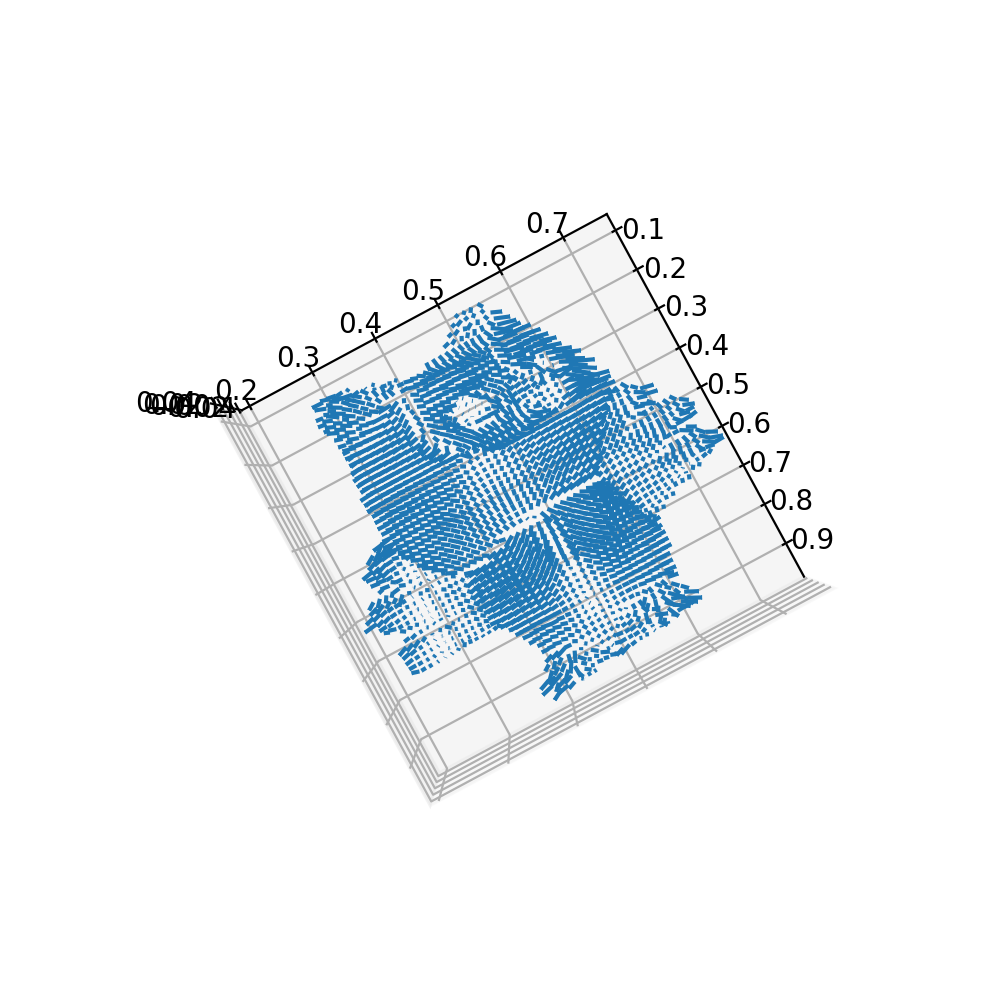

In [4]:
def normal_map(imgs, mask, L):
    channel = 3
    gs = np.zeros((channel, mask.shape[0], mask.shape[1], 3))
    albedos = np.zeros((channel, mask.shape[0], mask.shape[1]))
    gs[:, :, :, -1] = 1.0
    N = imgs.shape[0]
    I = np.zeros(N)
    
    for ch in range(channel):
        for coord, v in np.ndenumerate(mask):
            if v > 0:
                for i in range(N):
                    I[i] = imgs[i, coord[0], coord[1], ch]
#                 A = np.dot(L.T, L)
#                 b = np.dot(L.T, I.T)
#                 g = np.dot(np.linalg.inv(A), b)
                g, _, _, _ = np.linalg.lstsq(L, I)
                if not np.isnan(np.sum(g)):
                    gs[ch, coord[0], coord[1], :] = g
                    albedos[ch, coord[0], coord[1]] = np.linalg.norm(g)
    return gs, albedos

def vis_normal(mask, norms, ch, step, downscale):
    normal = norms[ch, :, :, :]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(np.arange(0, mask.shape[1], 1), np.arange(0, mask.shape[0], 1))
    z = np.zeros(x.shape)
    u = np.multiply(normal[:, :, 0], mask)
    v = np.multiply(normal[:, :, 1], mask)
    w = np.multiply(normal[:, :, 2], mask)

    xx = x[::step, ::step] / mask.shape[1]
    yy = y[::step, ::step] / mask.shape[0]
    zz = z[::step, ::step]
    
    uu = u[::step, ::step] / downscale
    vv = v[::step, ::step] / downscale
    ww = w[::step, ::step] / downscale

    ax.quiver(yy, xx, zz, vv, uu, ww, length=1, arrow_length_ratio=0.05)
    plt.show()


gs, albedos = normal_map(images, mask, L)
# Visualize for red channel
vis_normal(mask, gs, 0, 5, 5000)

# 4. Albedo Recovery

Use your code in problem 3 to independently estimate $g$ for each of the color channels.  The $g$ vectors you recover from the three channels should have different lengths (depending on the color of the surface) but the same
direction (depending only on the shape of the surface).  Use this fact to generate an image that shows the color albedo $(\rho_r,\rho_g,\rho_b)$ at each pixel and a quiver plot showing unit normal vectors describing the shape.


//anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
//anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


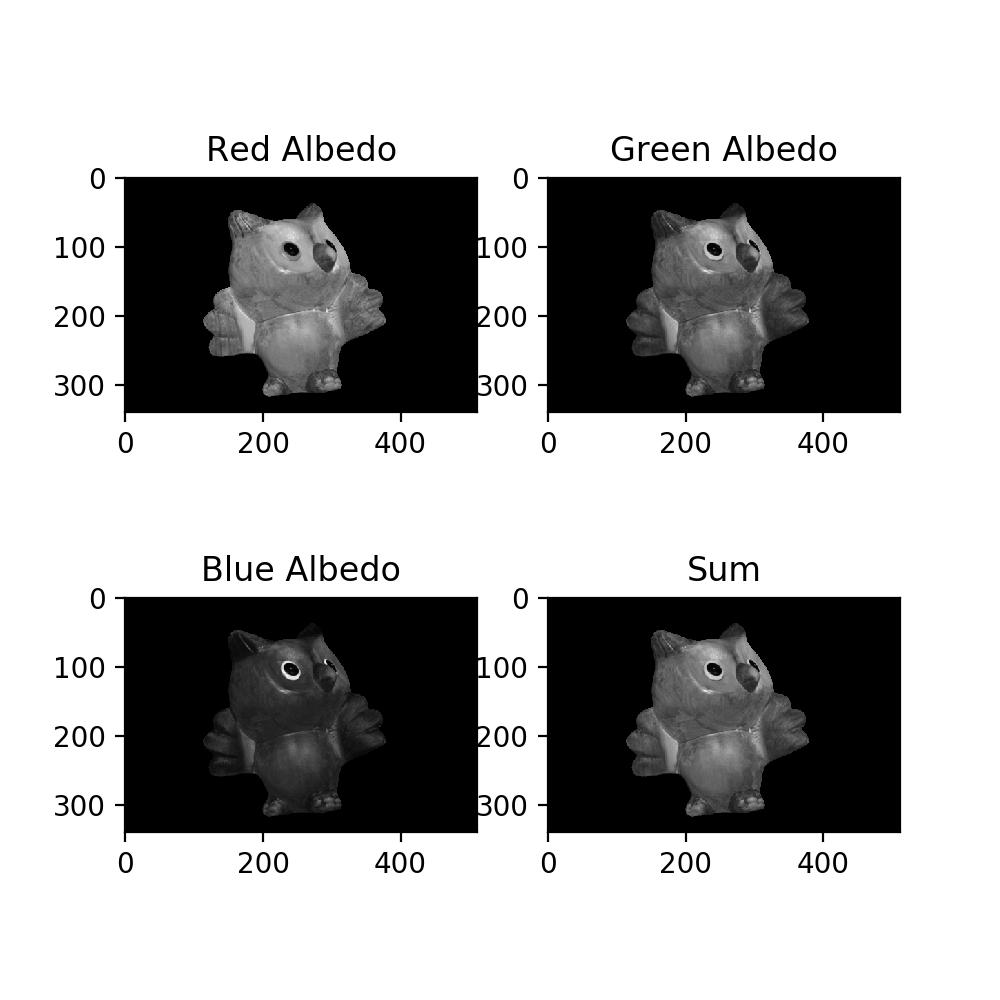

<IPython.core.display.Javascript object>


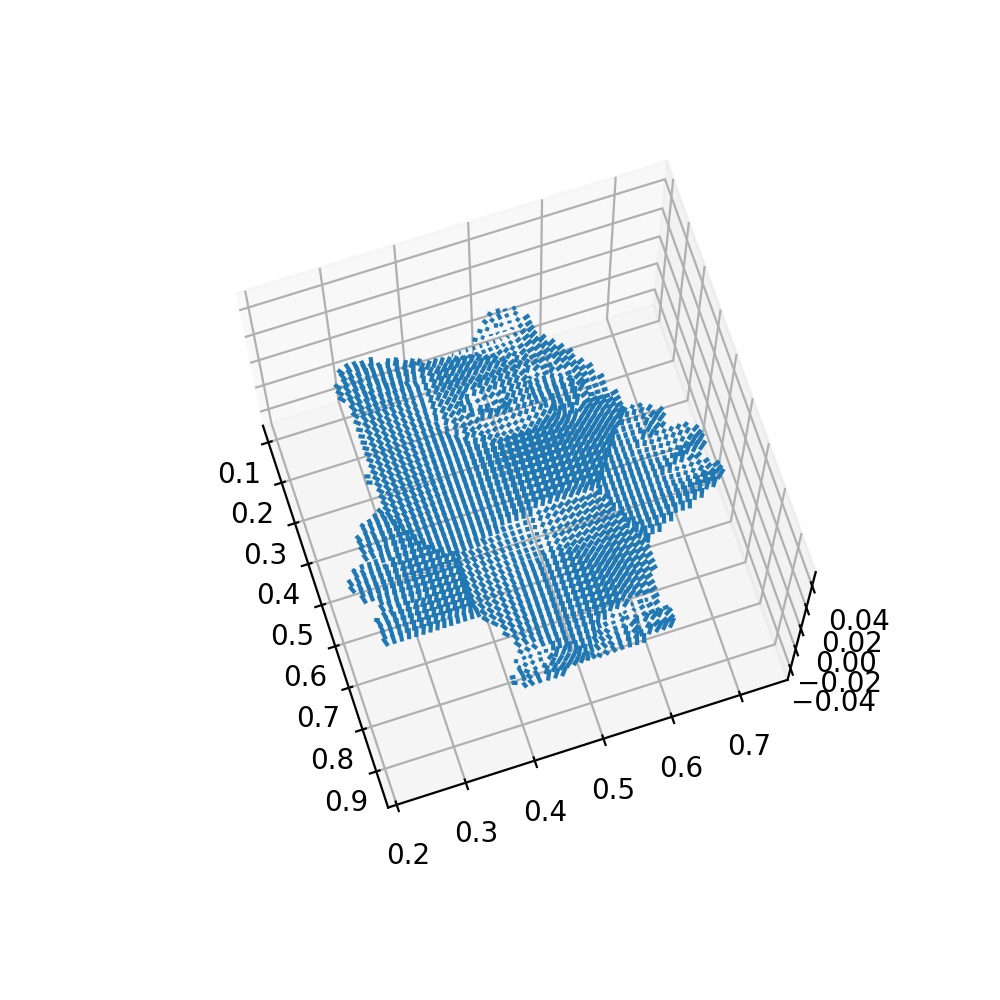

//anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
//anaconda/envs/py3/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:2689: RuntimeWarning: invalid value encountered in greater
  mask = norm > 0


In [20]:
def vis_albedo(albedos):
    titles = ["Red Albedo", "Green Albedo", "Blue Albedo", "Sum"]
    fig = plt.figure(figsize=(5, 5))
    for i in range(3):
        ax = fig.add_subplot(2, 2, i + 1)
        plt.imshow(albedos[i, :, :], cmap='gray', vmin = 0, vmax = 255)
        plt.title(titles[i])
    ax = fig.add_subplot(2, 2, 4)
    alb = np.transpose(albedos, (1, 2, 0))
    alb = np.sum(alb, axis=2)
    alb = np.interp(alb, (alb.min(), alb.max()), (0, 255))
    plt.imshow(alb, cmap='gray', vmin = 0, vmax = 255)
    plt.title(titles[3])
    plt.show()

normals = gs / np.repeat(albedos[:, :, :, np.newaxis], 3, axis=3)
vis_albedo(albedos)
vis_normal(mask, normals, 0, 5, 100)